# Meta-learning stochastic processes

#  Reptile algorithm

Reptile（Reptilian）是一种元学习算法，专门设计用于使模型能够快速适应有限数据的新任务。该算法由 OpenAI 在 2018 年发表的一篇题​​为“Reptile：一种可扩展元学习算法”的论文中引入。Reptile 背后的关键思想是通过重复采样任务、训练任务并更新模型参数来模拟元学习过程，以鼓励快速适应。

以下是 Reptile 算法的高级概述：

任务采样：从可用任务集中随机采样任务。

内循环（任务训练）：对采样任务执行几个步骤的训练（梯度更新）。这涉及使用少量特定于任务的数据使模型适应特定任务。

外循环（元更新）：在内循环训练后，将模型参数更新为适应模型。此元更新有助于模型更好地泛化不同的任务。

重复：通过返回步骤 1 进行预定义的迭代次数来重复该过程。

关键的见解是，通过重复采样和适应不同的任务，模型学习一组参数，可以用最少的数据快速适应新任务。这在为每个特定任务获取标记数据成本高昂或不切实际的情况下特别有用。

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the base model (task-specific)
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Define the meta-learner model
class MetaLearner(nn.Module):
    def __init__(self):
        super(MetaLearner, self).__init__()
        self.base_model = LinearRegression()
        self.optimizer = optim.SGD(self.base_model.parameters(), lr=0.01)

    def forward(self, x_support, y_support, x_query):
        # Training on support set
        predictions_support = self.base_model(x_support)
        loss_support = nn.MSELoss()(predictions_support, y_support)
        self.optimizer.zero_grad()
        loss_support.backward()
        self.optimizer.step()

        # Testing on query set
        predictions_query = self.base_model(x_query)

        return predictions_query

# Sample data for the base task
def generate_data():
    x = torch.rand(10, 1)  # 10 random input samples
    y = 2 * x + 1 + 0.1 * torch.randn_like(x)  # Linear relation with noise
    return x, y

# Meta-training loop
meta_learner = MetaLearner()
meta_iterations = 1000

for iteration in range(meta_iterations):
    # Generate a new base task
    x_support, y_support = generate_data()
    x_query, _ = generate_data()  # Query set (not used for updating the model)

    # Convert data to torch tensors
    x_support, y_support, x_query = map(torch.tensor, (x_support, y_support, x_query))

    # Perform a meta-learning update
    predictions_query = meta_learner(x_support, y_support, x_query)

    # Meta-learning update based on predictions_query
    # (In a more advanced setting, you might use higher-order gradients and more sophisticated optimization methods)

# Meta-testing (adapting to a new task)
new_task_x_support, new_task_y_support = generate_data()
new_task_x_query, _ = generate_data()
new_task_x_support, new_task_y_support, new_task_x_query = map(torch.tensor, (new_task_x_support, new_task_y_support, new_task_x_query))

# Use the meta-learner to quickly adapt to the new task
predictions_new_task = meta_learner(new_task_x_support, new_task_y_support, new_task_x_query)

print("Predictions for the new task:", predictions_new_task)


Predictions for the new task: tensor([[2.1150],
        [2.7749],
        [1.2953],
        [2.1180],
        [1.3382],
        [1.5312],
        [2.3091],
        [2.6435],
        [2.3297],
        [1.7227]], grad_fn=<AddmmBackward0>)


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_97120/3011008928.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_support, y_support, x_query = map(torch.tensor, (x_support, y_support, x_query))
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_97120/3011008928.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_task_x_support, new_task_y_support, new_task_x_query = map(torch.tensor, (new_task_x_support, new_task_y_support, new_task_x_query))


Standard Linear Regression Score: 0.9733030636120659
Meta-learning with Reptile Score: 0.9627472872781018


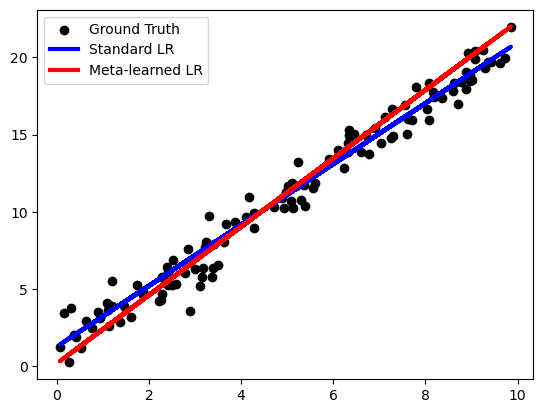

In [52]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(200, 1) * 10
y = 2 * X.squeeze() + 1 + np.random.randn(200)

# Split data into training and testing sets
split_idx = 80
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Standard Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Standard Linear Regression Score:", lr_score)

# Meta-learning using Reptile
def reptile_meta_learning(X, y, num_tasks, num_iterations, alpha=0.1):
    model = LinearRegression()
    
    for _ in range(num_iterations):
        task_indices = np.random.choice(len(X), size=num_tasks, replace=False)
        task_X, task_y = X[task_indices], y[task_indices]
        
        # Perform a gradient update on the model parameters using the task data
        model.fit(task_X, task_y)
        
        # Update the model parameters towards the current task
        model.coef_ += alpha * (task_X.T @ (task_y - task_X @ model.coef_)) / num_tasks

    return model

# Meta-learning using Reptile
meta_model = reptile_meta_learning(X_train, y_train, num_tasks=5, num_iterations=100, alpha=0.1)

# Evaluate the meta-learned model on the test set
meta_score = meta_model.score(X_test, y_test)
print("Meta-learning with Reptile Score:", meta_score)

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Ground Truth')
plt.plot(X_test, lr.predict(X_test), color='blue', linewidth=3, label='Standard LR')
plt.plot(X_test, meta_model.predict(X_test), color='red', linewidth=3, label='Meta-learned LR')
plt.legend()
plt.show()


# MAML (Model-Agnostic Meta-Learning)

Standard Neural Network MSE: 97.38752746582031
Meta-learning with Reptile MSE: 92.54110717773438


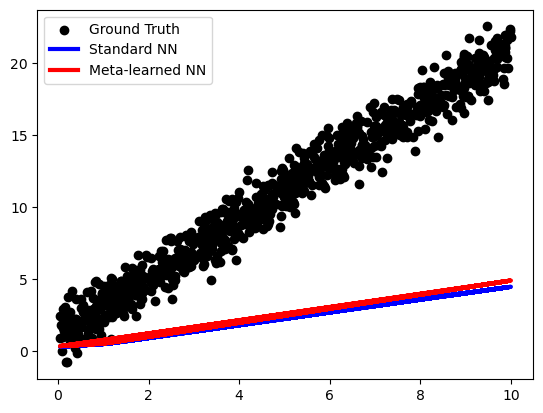

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(1000, 1) * 10
y = 2 * X.squeeze() + 1 + np.random.randn(1000)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split data into training and testing sets
split_idx = 80
X_train, y_train = X_tensor[:split_idx], y_tensor[:split_idx]
X_test, y_test = X_tensor[split_idx:], y_tensor[split_idx:]

# Standard Neural Network
class StandardNN(nn.Module):
    def __init__(self):
        super(StandardNN, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Meta-learning using Reptile
def reptile_meta_learning(X, y, num_tasks, num_iterations, alpha=0.1):
    model = StandardNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for _ in range(num_iterations):
        task_indices = np.random.choice(len(X), size=num_tasks, replace=False)
        task_X, task_y = X[task_indices], y[task_indices]

        for epoch in range(1):
            # Perform a gradient update on the model parameters using the task data
            predictions = model(task_X)
            loss = criterion(predictions, task_y.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the model parameters towards the current task
        # Update the model parameters towards the current task
        with torch.no_grad():
            for param, param_target in zip(model.parameters(), standard_nn.parameters()):
                param.add_(alpha * (param_target - param))


    return model

# Standard Neural Network
standard_nn = StandardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(standard_nn.parameters(), lr=0.001)

for epoch in range(100):
    # Standard training
    predictions = standard_nn(X_train)
    loss = criterion(predictions, y_train.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the standard neural network on the test set
with torch.no_grad():
    standard_nn.eval()
    standard_predictions = standard_nn(X_test)
    standard_nn_score = criterion(standard_predictions, y_test.view(-1, 1))
    print("Standard Neural Network MSE:", standard_nn_score.item())

# Meta-learning using Reptile
meta_nn = reptile_meta_learning(X_train, y_train, num_tasks=5, num_iterations=100, alpha=0.1)

# Evaluate the meta-learned model on the test set
with torch.no_grad():
    meta_nn.eval()
    meta_predictions = meta_nn(X_test)
    meta_nn_score = criterion(meta_predictions, y_test.view(-1, 1))
    print("Meta-learning with Reptile MSE:", meta_nn_score.item())

# Plot the results
plt.scatter(X_test.numpy(), y_test.numpy(), color='black', label='Ground Truth')
plt.plot(X_test.numpy(), standard_predictions.numpy(), color='blue', linewidth=3, label='Standard NN')
plt.plot(X_test.numpy(), meta_predictions.numpy(), color='red', linewidth=3, label='Meta-learned NN')
plt.legend()
plt.show()
